In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import pickle
import os
import sys
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  


sys.path.insert(1, '../../modules')
# handmade functions
from Rouss1 import *
from Rouss2 import *
from Rouss3D import *
from dis_flopy import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [9]:
#geo parameters
MNT_path = "../../data/surfaces_geoter/TOPO  (0 en mer).ASC"
x0,y0,x1,y1 = get_MNTbbox(MNT_path)

Lx = x1-x0
Ly = y1-y0
nlay = 5
res = 300

ncol = int(Lx/res)
nrow = int(Ly/res)

delr = np.ones(ncol)*res
delc = np.ones(nrow)*res

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data

In [3]:
# load differents surfaces

top = "../../data/surfaces_geoter/TOPO (inf_0 en mer).ASC"
surfQ  = "../../data/surfaces_geoter/Mur QUAT.ASC"
surfPC = "../../data/surfaces_geoter/Mur PC.ASC"
surfPMS = "../../data/surfaces_geoter/Mur PMS.ASC"

files_surf = [top,surfQ,surfPC,surfPMS]
surfaces=[]
for file in files_surf:
    Rast = Raster.load(file)
    surfaces.append(Rast.resample_to_grid(grid.xcellcenters,
                                grid.ycellcenters,
                                band = Rast.bands[0],
                                method="nearest"))

top = surfaces[0]
Q = surfaces[1]
PC = surfaces[2]
PMS = surfaces[3]
surfaces.insert(2,Q)

In [16]:
#domain
idomain = np.zeros([nlay,nrow,ncol])

for ilay in range(nlay-1):
    idomain[ilay+1] = active_dom(surfaces[ilay+1],grid)

In [18]:
#domain for the 1st and 2nd layers
shp_Q = "../../data/shp/entités/Q_extended.shp"
idomain[0:3] = 0
gp2cellids3D(grid,gp.read_file(shp_Q),idomain,layer=1);
idomain[2] = idomain[1]

In [19]:
#layer 0
shp = "../../data/shp/sea_bc_extended.shp"
gp2cellids3D(grid,gp.read_file(shp),idomain,layer=0);

In [20]:
# pseudo active cells
for ilay in range(nlay-2):
    for irow in range(nrow):
        for icol in range(ncol):
            icell = idomain[:,irow,icol]
            if (icell[:ilay+1]==1).any() & (icell[ilay+2:]==1).any() & (icell[ilay+1] == 0):
                idomain[ilay+1,irow,icol] = - 1

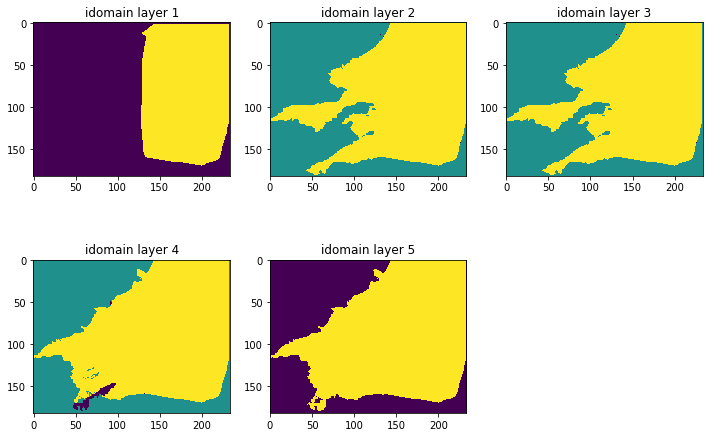

In [21]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(1,nlay+1):
    ax = fig.add_subplot(2, 3, i)
    g=ax.imshow(idomain[i-1])
    plt.title("idomain layer {}".format(i))

In [22]:
#surfaces and botom
botm = np.zeros([nlay,nrow,ncol])

bot_surf = top.copy() # a list that will contain infos about the bottom of a surface, update at each loop
for ilay in range(nlay):
   
    bot_surf[idomain[ilay] != 1] -= 0.1 # not in a the domain, 0.1 m of thickness

    if ilay == 2:
        bot_surf[idomain[ilay] == 1] = botm[1][idomain[ilay] == 1] - 2
    if ilay == 0:
        bot_surf[idomain[ilay] == 1] -= 2
    else:
        bot_surf[idomain[ilay] == 1] = surfaces[ilay][idomain[ilay] == 1] # where idomain for ilay is active --> bot_surf take the values of the surface

    botm[ilay] = bot_surf

In [25]:
MinThick(idomain,botm,top,min_ep_act=2,min_ep_inact=0.1)

In [26]:
check_thk(top,botm)

[False, False, False, False, False]

## we have created four layers, now we want to separate the Pliocene into multiple sublayers

### Let's define a function that can help with that 

In [27]:
def multi_lay(botm,idomain,ep=50,nsublay=4,layer=2):
    
    """
    subdivised a layer into sublayers, return two numpy 3D array, one is surface and the other the idomain associated 
    to these new layers
    """
    nlay = botm.shape[0]
    nrow = botm.shape[1]
    ncol = botm.shape[2]
    idomain_sub_lay = np.zeros([nsublay,nrow,ncol])
    botm_sub_lay = np.zeros([nsublay,nrow,ncol])
    thk = botm[layer-1]-botm[layer]
    
    #first sublayer
    botm_sub_lay[0] = botm[layer-1]
    botm_sub_lay[0][thk<0.2] -= 0.1
    botm_sub_lay[0][(thk<ep)&(thk>0.2)] = botm[layer][(thk<ep)&(thk>0.2)]
    botm_sub_lay[0][thk>ep] -= ep
    
    #idomain 1st sublayer
    idomain_sub_lay[0][thk>0.2] = 1
    
    #between 1st and nth 
    for isublay in range(1,nsublay-1):
        botm_sub_lay[isublay] = botm_sub_lay[isublay-1].copy()
        botm_sub_lay[isublay][thk<isublay*ep] -= 0.1
        mask = (thk<(ep*(isublay+1)))&(thk>isublay*ep)
        botm_sub_lay[isublay][mask] = botm[layer][mask]
        botm_sub_lay[isublay][thk>(ep*(isublay+1))] -= ep
        
        idomain_sub_lay[isublay][thk>isublay*ep] = 1
    
    if nsublay==2:
        isublay=0
        
    #last sublayer
    botm_sub_lay[-1] =  botm_sub_lay[isublay].copy()
    botm_sub_lay[-1][thk<(isublay+1)*ep] -= 0.1
    mask = (thk>(isublay+1)*ep)
    botm_sub_lay[-1][mask] = botm[layer][mask]

    idomain_sub_lay[-1][thk>(isublay+1)*ep] = 1

    #new subdivised botom
    new_botm = np.ones([nlay+nsublay-1,nrow,ncol])
    new_botm[0:layer]=botm[0:layer]
    new_botm[layer:layer+nsublay] = botm_sub_lay
    new_botm[layer+nsublay:] = botm[layer+1:]
    
    #new subdivised idomain
    new_idomain = np.ones([nlay+nsublay-1,nrow,ncol])
    new_idomain[0:layer]=idomain[0:layer]
    new_idomain[layer:layer+nsublay] = idomain_sub_lay
    new_idomain[layer+nsublay:] = idomain[layer+1:]
    
    return new_botm,new_idomain

In [28]:
#Split the Pliocene (layer = 3)
new_botm,new_idomain = multi_lay(botm,idomain,ep=50,nsublay=4,layer=3)

In [29]:
#create semi-impermable layers btw pliocene layers

new_botm,new_idomain = multi_lay(new_botm,new_idomain,ep=2,nsublay=2,layer=4)
new_botm,new_idomain = multi_lay(new_botm,new_idomain,ep=2,nsublay=2,layer=6)
new_botm,new_idomain = multi_lay(new_botm,new_idomain,ep=2,nsublay=2,layer=8)

In [32]:
# pseudo active cells
for ilay in range(11-2):
    for irow in range(nrow):
        for icol in range(ncol):
            icell = new_idomain[:,irow,icol]
            if (icell[:ilay+1]==1).any() & (icell[ilay+2:]==1).any() & (icell[ilay+1] == 0):
                new_idomain[ilay+1,irow,icol] = - 1

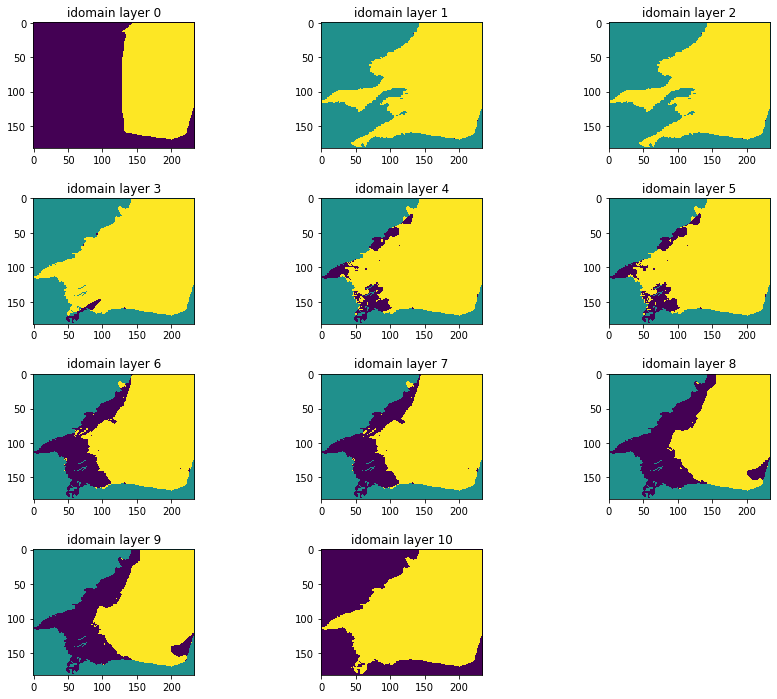

In [33]:
fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(hspace=0.4, wspace=0.1)
for i in range(1,new_idomain.shape[0]+1):
    g = ax = fig.add_subplot(4, 3, i)
    ax.imshow(new_idomain[i-1])
    plt.title("idomain layer {}".format(i-1))

In [34]:
while np.array(check_thk(top,new_botm)).any():
    MinThick(new_idomain,new_botm,top,min_ep_act=2,min_ep_inact=0.1)
check_thk(top,new_botm)

[False, False, False, False, False, False, False, False, False, False, False]

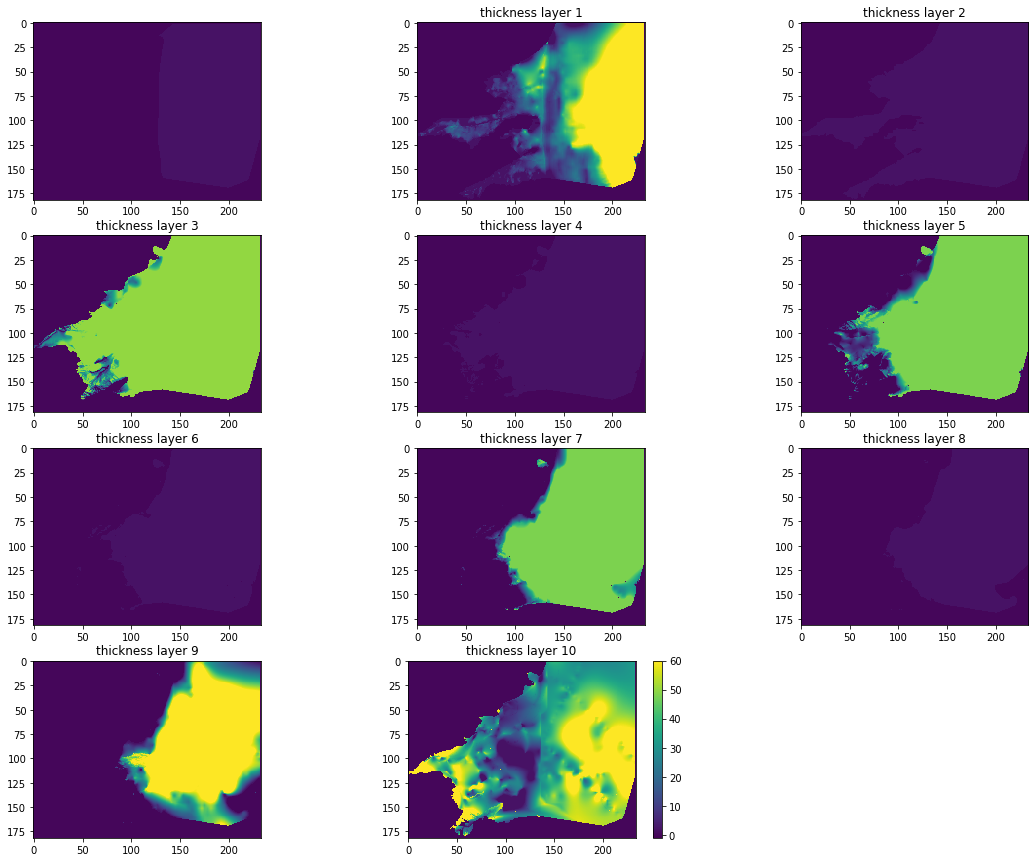

In [42]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
ax = fig.add_subplot(4, 3, 1)
a = ax.imshow(top-new_botm[0])
a.set_clim(-1,60)
for i in range(1,new_botm.shape[0]):
    ax = fig.add_subplot(4, 3, i+1)
    a = ax.imshow(new_botm[i-1]-new_botm[i])
    a.set_clim(-1,60)
    plt.title("thickness layer {}".format(i))

plt.colorbar(a)

In [41]:
newpath = "working"
if not os.path.exists(newpath):
    os.makedirs(newpath)
write_pickle("working/export_dis",[top,new_botm,new_idomain])